## Compound
Retrieve images linked to a given set of compounds and check the concentration used.

### Import libraries 

In [1]:
import csv
import os
import pandas as pd
from tempfile import NamedTemporaryFile

import scipy
import numpy
from skimage import filters
import matplotlib.pyplot as plt
from idr import connection

import requests

### Set up where to query and session 

In [2]:
INDEX_PAGE = "https://idr.openmicroscopy.org/webclient/?experimenter=-1"

# create http session
with requests.Session() as session:
    request = requests.Request('GET', INDEX_PAGE)
    prepped = session.prepare_request(request)
    response = session.send(prepped)
    if response.status_code != 200:
        response.raise_for_status()

### Compounds to query 

In [3]:
compounds = ['loratadine', 'cycloheximide', 'ML9', 'ML-9']

### Set up base URLS so can use shorter variable names later on

In [4]:
URL = "https://idr.openmicroscopy.org/mapr/api/{key}/?value={value}&case_sensitive=false&orphaned=true"
SCREENS_PROJECTS_URL = "https://idr.openmicroscopy.org/mapr/api/{key}/?value={value}&case_sensitive=false&id={compound_id}"
PLATES_URL = "https://idr.openmicroscopy.org/mapr/api/{key}/plates/?value={value}&id={screen_id}&case_sensitive=false"
IMAGES_URL = "https://idr.openmicroscopy.org/mapr/api/{key}/images/?value={value}&node={parent_type}&id={parent_id}&case_sensitive=false"
ATTRIBUTES_URL = "https://idr.openmicroscopy.org/webclient/api/annotations/?type=map&image={image_id}"

### Find images for each compound specified
For each compound, search of images in plates then search for annotations associated with the images. The results are saved in a CSV file. 

In [5]:
TYPE = "compound"
KEYS = {TYPE:
    ("InChIKey",
     "PubChem InChIKey",
     "Compound Concentration (microMolar)",
     "Concentration (microMolar)",
     "Dose",
     "Compound MoA",
     "Compound Action")
}

#### Helper method
Parse the output of the json and save it into the CSV file.

In [19]:
def parse_annotation(writer, json_data, name, data_type):
    plate_name = "-"
    screen_name = name
    for p in json_data[data_type]:
        parent_id = p['id']
        plate_name = p['name']
        qs3 = {'key': TYPE, 'value': compound,
                'parent_type': data_type[:-1], 'parent_id': parent_id}
        url3 = IMAGES_URL.format(**qs3)
        c = compound.lower()
        if c.startswith("ml"):
            c = 'ml9'
        for i in session.get(url3).json()['images']:
            image_id = i['id']
            url4 = ATTRIBUTES_URL.format(**{'image_id': image_id})
            row = {}
            inchikey = "-"
            concentration = "-"
            moa = "-"
            for a in session.get(url4).json()['annotations']:
                for v in a['values']:
                    key = str(v[0])
                    if key in KEYS[TYPE]:
                        if key in ['InChIKey', 'PubChem InChIKey']:
                            inchikey = v[1]
                        elif key in ['Dose', 'Compound Concentration (microMolar)', 'Concentration (microMolar)']:
                            concentration = float(v[1].replace(' micromolar', ''))
                        elif key in ['Compound MoA', 'Compound Action']:
                            moa = v[1]
            row.update({'Compound': c,
                        'Screen': screen_name,
                        'Plate': plate_name,
                        'Image': image_id,
                        'InChIKey': inchikey,
                        'Concentration': concentration,
                        'MoA': moa})
            writer.writerow(row)

#### Retrieve data 
A CSV file is first created in the ``home`` directory. The CSV file can then be downloaded to your local machine. To download it, click ``File > Open``, select the CSV file and open it, then click ``File > Download``.

In [20]:
home = os.path.expanduser("~")
csvfile = NamedTemporaryFile("w", delete=False, newline='', dir=home, suffix=".csv")
try:
    fieldnames = [
        'Compound', 'Screen', 'Plate', 'Image',
        'InChIKey', 'Concentration', 'MoA']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for compound in compounds:
        qs1 = {'key': TYPE, 'value': compound}
        url1 = URL.format(**qs1)
        json = session.get(url1).json()
        for m in json['maps']:
            qs2 = {'key': TYPE, 'value': compound, 'compound_id': m['id']}
            url2 = SCREENS_PROJECTS_URL.format(**qs2)
            json = session.get(url2).json()
            for s in json['screens']:
                compound = s['extra']['value']
                qs3 = {'key': TYPE, 'value': compound, 'screen_id': s['id']}
                url3 = PLATES_URL.format(**qs3)
                parse_annotation(writer, session.get(url3).json(), s['name'], 'plates')
finally:
    csvfile.close()

### Explore the data
Read the generated CSV file into a dataframe.

In [41]:
df = pd.read_csv(csvfile.name)
df = df.sort_values(by=['Concentration'])
df

,Compound,Screen,Plate,Image,InChIKey,Concentration,MoA
659,loratadine,idr0017-breinig-drugscreen/screenA (96),MEK2-/-_LOPAC_Plate_3_Replicate_1,1694384,-,-,Antagonist
1865,ml9,idr0017-breinig-drugscreen/screenA (96),PI3KCA_mt-/wt+_LOPAC_Plate_1_Replicate_2,1753645,-,-,Inhibitor
654,loratadine,idr0017-breinig-drugscreen/screenA (96),MEK1-/-_LOPAC_Plate_3_Replicate_2,1794680,-,-,Antagonist
655,loratadine,idr0017-breinig-drugscreen/screenA (96),MEK1-/-_LOPAC_Plate_3_Replicate_2,1794681,-,-,Antagonist
1866,ml9,idr0017-breinig-drugscreen/screenA (96),PTEN-/-_LOPAC_Plate_1_Replicate_1,1739999,-,-,Inhibitor
...,...,...,...,...,...,...,...
229,loratadine,idr0088-cox-phenomicprofiling/screenA (560),110000251707,10810449,JCCNYMKQOSZNPW-UHFFFAOYSA-N,9.0,Histamine receptor antagonist
227,loratadine,idr0088-cox-phenomicprofiling/screenA (560),110000251707,10810450,JCCNYMKQOSZNPW-UHFFFAOYSA-N,9.0,Histamine receptor antagonist
577,loratadine,idr0088-cox-phenomicprofiling/screenA (560),110000252523,11361781,JCCNYMKQOSZNPW-UHFFFAOYSA-N,9.0,Histamine receptor antagonist
585,loratadine,idr0088-cox-phenomicprofiling/screenA (560),110000252601,11402348,JCCNYMKQOSZNPW-UHFFFAOYSA-N,9.0,Histamine receptor antagonist


### Plot histogram
Plot the concentration vs the number of images for each compound

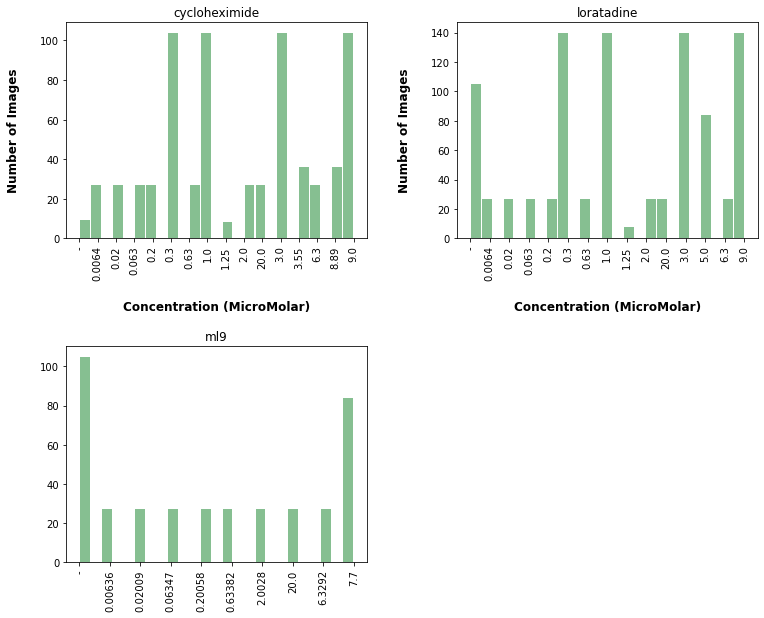

In [42]:
ax = df.hist(column='Concentration', by="Compound", bins=25, grid=False, figsize=(12,10), color='#86bf91', zorder=2, rwidth=0.9)
ax = ax[0]
for x in ax:
    # Set x-axis label
    x.set_xlabel("Concentration (MicroMolar)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Number of Images", labelpad=20, weight='bold', size=12)

Copyright (C) 2021 University of Dundee. All Rights Reserved.
This program is free software; you can redistribute it and/or modify it
under the terms of the GNU General Public License as published by the
Free Software Foundation; either version 2 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY
or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for
more details. You should have received a copy of the GNU General
Public License along with this program; if not, write to the
Free Software Foundation,
Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA. 